<a href="https://colab.research.google.com/github/MojdehAzizian/NLP_topic_modeling/blob/main/NLP_LiteratureClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>
<b>Loading libraries and installing dependencies</b>

In [1]:
!pip install langdetect
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz (531.2 MB)
  Preparing metadata (setup.py) ... done


In [23]:
import numpy as np
import pandas as pd

from statistics import mode
import re

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_formats = ['svg']
import seaborn as sns

from tqdm import tqdm

from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_blobs

<font size=6>
<b>Dataset</b>

Loading dataset

In [ ]:
!kaggle datasets download -d fabiochiusano/medium-articles

In [9]:
import zipfile
import os

zip_file_path = '/content/medium-articles.zip'

extract_dir = '/content'
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'Files extracted to: {extract_dir}')

Files extracted to: /content


<font size=6>
<b>Dataframe</b>

First, we need to make the dataframe and fill the Null values with space

In [10]:
df = pd.read_csv('medium_articles.csv')
df.head()

,title,text,url,authors,timestamp,tags
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci..."
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P..."
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We..."
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P..."
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology..."


In [11]:
df.fillna(value=" ",inplace=True)
df = df.sample(1500, random_state=42)
df.head()

,title,text,url,authors,timestamp,tags
51649,2018: Is the Crypto HYPE real?,→ Flagman\n\nIt seems logical to start the inv...,https://medium.com/cc-connecting-crypto-with-b...,[],2018-01-25 10:55:14.696000+00:00,"['Bitcoin', 'Adoption', 'Humor', 'Cryptocurren..."
68568,Liberal Arts Blog — the Brain — What is the Mo...,Liberal Arts Blog — Wednesday is the Joy of Sc...,https://medium.com/@john-muresianu/liberal-art...,['John Muresianu'],2020-12-09 13:57:22.716000+00:00,"['Phisiology', 'Education', 'Liberal Arts Blog..."
176024,Month one is a wrap!! #WenHop,We want to give a huge shout out to our early ...,https://medium.com/@marseconomy/month-one-is-a...,['Mars Economy'],2021-06-17 20:05:16.168000+00:00,"['Entrepreneurship', 'Mars', 'Cryptocurrency',..."
59788,10 Principles For Schools of Modern Learning,It’s time to raise the bar on our conversation...,https://medium.com/modern-learning/10-principl...,['Will Richardson'],2017-01-31 15:51:54.291000+00:00,"['Education', 'Tech', 'Learning', 'Change']"
58637,Narcissistic Sociopathy of Wealth,Seeking Arrangement and tech bro CEO’s fashion...,https://ljgolden55.medium.com/narcissistic-soc...,['Lester Golden'],2020-12-29 11:35:54.699000+00:00,"['Wealth', 'Capitalism', 'Sex', 'Love', 'Relat..."


<font size=6>
<b>preprocessing the text</b>


using Spacy, NLTK adn Gensim to preprocess the texts, for that, these steps are considered:

1-recognizing language used in the text

2-tokenization

3-stemming and lematization

4-removing stopwords

5-removing punctuations

In [12]:
languages = []
df = df.reindex(columns = df.columns.tolist() + ['language'])

for txt in df["text"]:
  if txt == " ":
    languages.append(" ")
  else:
    lang = detect(txt)
    languages.append(lang)

df = df.assign(language = languages)
print(mode(df["language"]))

en


<font size=5>
since the major of the data is English texts, here we just consider English texts

In [13]:
en = df["language"] != 'en'
df = df[~en]
df.head()

,title,text,url,authors,timestamp,tags,language
51649,2018: Is the Crypto HYPE real?,→ Flagman\n\nIt seems logical to start the inv...,https://medium.com/cc-connecting-crypto-with-b...,[],2018-01-25 10:55:14.696000+00:00,"['Bitcoin', 'Adoption', 'Humor', 'Cryptocurren...",en
68568,Liberal Arts Blog — the Brain — What is the Mo...,Liberal Arts Blog — Wednesday is the Joy of Sc...,https://medium.com/@john-muresianu/liberal-art...,['John Muresianu'],2020-12-09 13:57:22.716000+00:00,"['Phisiology', 'Education', 'Liberal Arts Blog...",en
176024,Month one is a wrap!! #WenHop,We want to give a huge shout out to our early ...,https://medium.com/@marseconomy/month-one-is-a...,['Mars Economy'],2021-06-17 20:05:16.168000+00:00,"['Entrepreneurship', 'Mars', 'Cryptocurrency',...",en
59788,10 Principles For Schools of Modern Learning,It’s time to raise the bar on our conversation...,https://medium.com/modern-learning/10-principl...,['Will Richardson'],2017-01-31 15:51:54.291000+00:00,"['Education', 'Tech', 'Learning', 'Change']",en
58637,Narcissistic Sociopathy of Wealth,Seeking Arrangement and tech bro CEO’s fashion...,https://ljgolden55.medium.com/narcissistic-soc...,['Lester Golden'],2020-12-29 11:35:54.699000+00:00,"['Wealth', 'Capitalism', 'Sex', 'Love', 'Relat...",en


In [15]:
parser = spacy.load('en_core_sci_lg', disable=["tagger", "ner"])
parser.max_length = 3000000

# Function to split text into sentences
def split_into_sentences(text):
    return re.split(r"[.!?]", text)

# Assuming df is your DataFrame
for txt in tqdm(df["text"], desc="Processing texts"):
    sentences = split_into_sentences(txt)
    for sentence in tqdm(sentences, desc='Processing sentence'):
        doc = parser(sentence)  # Process each sentence, not the entire text
        df['tokenized_sents'] = df['text'].apply(lambda text: [token.text for token in parser(text)])

def lemmatization(t):
    doc = parser(" ".join(t))
    return [token.lemma_ for token in doc]

def remove_stops(lemmas):
    return [token for token in lemmas if token.lower() not in parser.Defaults.stop_words]

def filter_text(lemmas):
    return [word for word in lemmas if word not in string.punctuation]

# Apply the functions to the DataFrame
df['lemma'] = df['tokenized_sents'].apply(lambda x: lemmatization(x))
df['removed_stops'] = df['lemma'].apply(remove_stops)
df["filtered_text"] = df["removed_stops"].apply(filter_text)

# Display the first few rows of the DataFrame
df.head()

Processing sentence:   0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)

Processing texts: 100%|██████████| 10/10 [11:42<00:00, 70.23s/it]


,title,text,url,authors,timestamp,tags,language,tokenized_sents,lemma,removed_stops,filtered_text
51649,2018: Is the Crypto HYPE real?,→ Flagman\n\nIt seems logical to start the inv...,https://medium.com/cc-connecting-crypto-with-b...,[],2018-01-25 10:55:14.696000+00:00,"['Bitcoin', 'Adoption', 'Humor', 'Cryptocurren...",en,"[→, Flagman, \n\n, It, seems, logical, to, sta...","[→, flagman, \n\n , it, seems, logical, to, st...","[→, flagman, \n\n , logical, start, investigat...","[→, flagman, \n\n , logical, start, investigat..."
68568,Liberal Arts Blog — the Brain — What is the Mo...,Liberal Arts Blog — Wednesday is the Joy of Sc...,https://medium.com/@john-muresianu/liberal-art...,['John Muresianu'],2020-12-09 13:57:22.716000+00:00,"['Phisiology', 'Education', 'Liberal Arts Blog...",en,"[Liberal, Arts, Blog, —, Wednesday, is, the, J...","[liberal, arts, blog, —, wednesday, is, the, j...","[liberal, arts, blog, —, wednesday, joy, scien...","[liberal, arts, blog, —, wednesday, joy, scien..."
176024,Month one is a wrap!! #WenHop,We want to give a huge shout out to our early ...,https://medium.com/@marseconomy/month-one-is-a...,['Mars Economy'],2021-06-17 20:05:16.168000+00:00,"['Entrepreneurship', 'Mars', 'Cryptocurrency',...",en,"[We, want, to, give, a, huge, shout, out, to, ...","[we, want, to, give, a, huge, shout, out, to, ...","[want, huge, shout, early, community, month, s...","[want, huge, shout, early, community, month, s..."
59788,10 Principles For Schools of Modern Learning,It’s time to raise the bar on our conversation...,https://medium.com/modern-learning/10-principl...,['Will Richardson'],2017-01-31 15:51:54.291000+00:00,"['Education', 'Tech', 'Learning', 'Change']",en,"[It, ’s, time, to, raise, the, bar, on, our, c...","[it, ’s, time, to, raise, the, bar, on, our, c...","[time, raise, bar, conversations, school, chan...","[time, raise, bar, conversations, school, chan..."
58637,Narcissistic Sociopathy of Wealth,Seeking Arrangement and tech bro CEO’s fashion...,https://ljgolden55.medium.com/narcissistic-soc...,['Lester Golden'],2020-12-29 11:35:54.699000+00:00,"['Wealth', 'Capitalism', 'Sex', 'Love', 'Relat...",en,"[Seeking, Arrangement, and, tech, bro, CEO, ’s...","[seeking, arrangement, and, tech, bro, ceo, ’s...","[seeking, arrangement, tech, bro, ceo, fashion...","[seeking, arrangement, tech, bro, ceo, fashion..."


<font size=6>
<b> feature extraction </b>

using tf_idf algorithm

In [17]:
df["filtered_text_str"] = df["filtered_text"].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(max_features=4096)
X = vectorizer.fit_transform(df["filtered_text_str"])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,000,10,100,1022,11,110,119,12,13,1305,...,year,years,yes,young,yourself,youtube,youtubers,zaki,zane,zero
0,0.024268,0.000000,0.000000,0.0,0.0,0.0,0.0,0.027738,0.0,0.0,...,0.021576,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.06526
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.026011,0.026011,0.000000,0.0,0.029731,0.0,0.0,0.0,0.00000
2,0.035521,0.000000,0.040601,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000
3,0.000000,0.041975,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.073501,0.000000,0.073501,0.0,0.000000,0.0,0.0,0.0,0.00000


<font size=6>
<b> PCA </b>

dimensionality reduction using PCA with maintaining 95% variance

In [20]:
scalar = StandardScaler()
df_scaled = pd.DataFrame(scalar.fit_transform(tfidf_df), columns=tfidf_df.columns)

df_scaled.head()

pca = PCA()
df_pca = pd.DataFrame(pca.fit_transform(df_scaled))

df_pca.head()

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= 0.95) + 1

df_reduced = df_pca.iloc[:, :num_components]

df_reduced.head()
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10 non-null     float64
 1   1       10 non-null     float64
 2   2       10 non-null     float64
 3   3       10 non-null     float64
 4   4       10 non-null     float64
 5   5       10 non-null     float64
 6   6       10 non-null     float64
 7   7       10 non-null     float64
dtypes: float64(8)
memory usage: 768.0 bytes


<font size=6>
<b> Clustering </b>

using Elbow Method for K-Means clustering

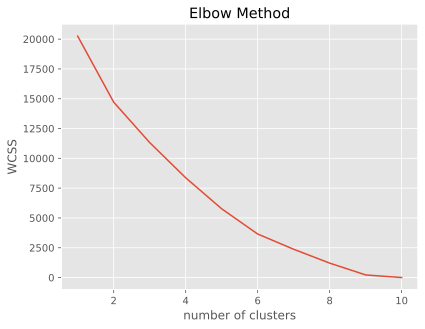

In [21]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=30, n_init=10, random_state=0)
    kmeans.fit(df_reduced)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('number of clusters')

plt.ylabel('WCSS')
plt.show()

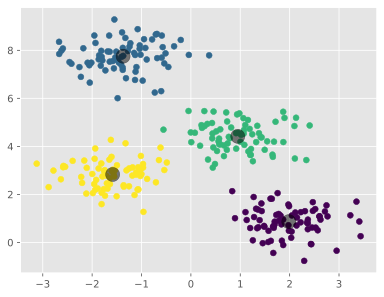

In [24]:
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

plt.show()

<font size=6>
<b> t-SNE </b>

using t-SNE for visualizing feaures in 2 dimensions

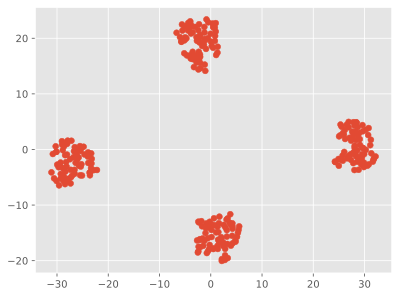

In [25]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.show()

<font size=6>
<b> Topic Modeling</b>

labeling clusters using LDA algorithm

In [26]:
X = MinMaxScaler().fit_transform(X)

def lda_per_cluster(data, n_topics):
  model = LatentDirichletAllocation(n_components=n_topics, random_state=0)
  model.fit(data)
  return model.components_, model.perplexity(data)

cluster_data = {}
for i in range(4):
  cluster_data[i] = X[kmeans.labels_ == i]

cluster_topics = {}
for cluster_id, data in cluster_data.items():
  if len(data) > 0:
    topics, _ = lda_per_cluster(data, 4)
    cluster_topics[cluster_id] = topics
  else:
    print(f"Skipping cluster {cluster_id} due to no data")

for cluster_id, topics in cluster_topics.items():
  print(f"\nCluster {cluster_id} Topics:")
  for topic_idx, topic in enumerate(topics):
    print(f" Topic {topic_idx+1}:", ", ".join([str(word_idx) for word_idx in topic.argsort()[:-11:-1]]))


Cluster 0 Topics:
 Topic 1: 0, 1
 Topic 2: 0, 1
 Topic 3: 0, 1
 Topic 4: 0, 1

Cluster 1 Topics:
 Topic 1: 1, 0
 Topic 2: 1, 0
 Topic 3: 1, 0
 Topic 4: 1, 0

Cluster 2 Topics:
 Topic 1: 0, 1
 Topic 2: 0, 1
 Topic 3: 0, 1
 Topic 4: 0, 1

Cluster 3 Topics:
 Topic 1: 1, 0
 Topic 2: 1, 0
 Topic 3: 1, 0
 Topic 4: 1, 0
